## Experiment Discription

In this experiment, we use fixed $\frac{\alpha}{\beta}$ ratio and fixed layers. We are trying to change style images and see the result.

In [95]:
import numpy as np 
import torch
from torch import nn
from torch.nn import functional as F 
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision as tv




device = 'cuda' if torch.cuda.is_available() else 'cpu' 




def getimage(image_path,image_size=(512,512)):
    transform = tv.transforms.Compose([
            tv.transforms.Resize(image_size),
            tv.transforms.ToTensor(),
            ])
    img = Image.open(image_path).convert('RGB')
    img = transform(img)
    img = img[None,:,:,:]
    return img.to(device, torch.float)




def myimshow(image,title,save=False,ax=plt):
    fig=plt.figure()  
    image = image.squeeze(0) 
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1]) 
    h = ax.imshow(image) 
    ax.axis('off') 
    
    if save:
        fig.savefig('{}.jpg'.format(title))
    return h,image

class NormalizeModule(nn.Module):
    def __init__(self):
        super(NormalizeModule, self).__init__()
        self.mean = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)
        self.std = torch.tensor([0.5, 0.5, 0.5]).view(-1, 1, 1).to(device)

    def forward(self, x):
        f = (x - self.mean) / self.std
        return f


class ClossModule(nn.Module):

    def __init__(self, f_content,):
        super(ClossModule, self).__init__()
        self.f_content = f_content.detach()

    def forward(self, x):
        self.loss = F.mse_loss(x, self.f_content)/2
        return x

def gram_matrix(x):
        B, N, W, H = x.size()  
        f = x.view(B*N, W*H)  
        G = torch.mm(f, f.t())/(2*B*N*W*H)  
        return G


class SlossModule(nn.Module):

    def __init__(self, f_style):
        super(SlossModule, self).__init__()
        self.G_style = gram_matrix(f_style).detach()

    def forward(self, x):
        G_input = gram_matrix(x)
        self.loss = F.mse_loss(G_input, self.G_style)
        return x




def getmodel(style_img, content_img,content_layers,style_layers):
    
    vgg = tv.models.vgg19(pretrained=True).features.to(device)
    
    model = nn.Sequential()
    model.add_module('Normalization', NormalizeModule().to(device))

    i = 0  
    j = 0
    m = 0
    n = 0
    for layer in vgg:
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'Conv_{}'.format(i)
        else:
            if isinstance(layer, nn.ReLU):
                layer = nn.ReLU(inplace=False)
            j += 1
            name = 'Notconv_{}'.format(j)

        model.add_module(name, layer)

        if name[5:] in str(content_layers):
            m += 1
            f_content = model(content_img).detach()
            Closs = ClossModule(f_content)
            model.add_module("Closs_{}".format(m), Closs)
          

        if name[5:] in str(style_layers):
            n += 1
            f_style = model(style_img).detach()
            Sloss = SlossModule(f_style)
            model.add_module("Sloss_{}".format(n), Sloss)
            
        if m==len(content_layers) and n==len(style_layers):
            break
    return model



def nst(input_img,content_img, style_img,
                       content_layers,style_layers,
                       style_weight=1000000, content_weight=1,tol=np.inf,T=3000):
    
    model = getmodel(style_img, content_img,content_layers,style_layers)
    optimizer = torch.optim.Adam([input_img.requires_grad_()])
    n_active = len(style_layers)
    epoch=0
    running_loss=np.inf
    while epoch<T or running_loss>tol:
        
        optimizer.zero_grad()
        model(input_img)
        style_loss = 0
        content_loss = 0

        for name, module in model.named_children():
            if 'Sloss' in name:
                style_loss += module.loss
            if 'Closs' in name:
                content_loss += module.loss

        loss = style_weight*style_loss/n_active + content_weight*content_loss
        loss.backward()

        optimizer.step()
        
        
        running_loss = loss.item()
        if epoch % 300 == 0:
            print("epoch : {}:".format(epoch))
            print('Weighted Loss : {}'.format(running_loss))
        epoch += 1
    input_img.data.clamp_(0, 1)
    return input_img


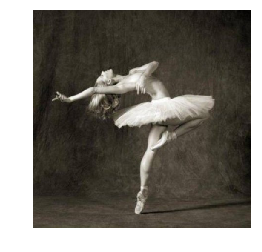

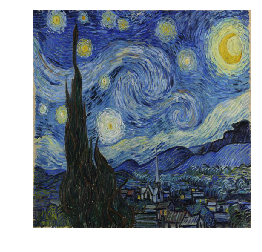

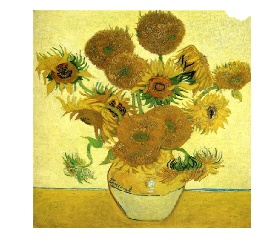

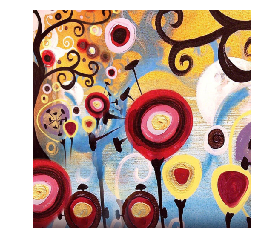

In [28]:
# style_img = getimage('./images/the-starry-night.jpg!Large.jpeg')
style_imgs = ['starry.jpg', 'style2.jpg', 'style3.jpg']
titles = ['starry_night', 'candy',  'sunflowers']
content_img = getimage('dancing.jpg')
# myimshow(style_img,'style_img')
_,_=myimshow(content_img,'content_img')
for i in range(3):
    style_img = getimage(style_imgs[i])
    _,_=myimshow(style_img,titles[i])



In [29]:
content_layers_0 = [4]
style_layers_4 = [1,2,3,4]

In [96]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 24.48284912109375
epoch : 300:
Weighted Loss : 3.355921745300293
epoch : 600:
Weighted Loss : 2.460519790649414
epoch : 900:
Weighted Loss : 2.287065267562866
epoch : 1200:
Weighted Loss : 2.2333905696868896
epoch : 1500:
Weighted Loss : 2.2038276195526123
epoch : 1800:
Weighted Loss : 2.184321403503418
epoch : 2100:
Weighted Loss : 2.1701178550720215
epoch : 2400:
Weighted Loss : 2.1591527462005615
epoch : 2700:
Weighted Loss : 2.150336742401123


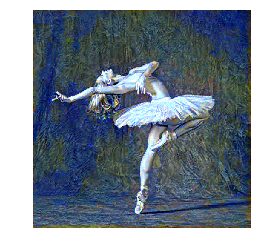

In [97]:
style_img = getimage(style_imgs[0])
output_1_exp1 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
_,op1=myimshow(output_1_exp1.detach(),titles[0],save=True)

In [98]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 22.484695434570312
epoch : 300:
Weighted Loss : 3.8987488746643066
epoch : 600:
Weighted Loss : 2.637392282485962
epoch : 900:
Weighted Loss : 2.238217830657959
epoch : 1200:
Weighted Loss : 1.9820177555084229
epoch : 1500:
Weighted Loss : 1.7964892387390137
epoch : 1800:
Weighted Loss : 1.6540192365646362
epoch : 2100:
Weighted Loss : 1.5426093339920044
epoch : 2400:
Weighted Loss : 1.4570014476776123
epoch : 2700:
Weighted Loss : 1.393683671951294


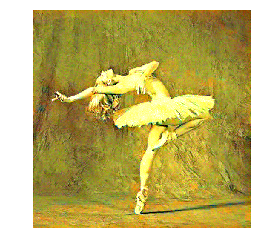

In [99]:
style_img = getimage(style_imgs[1])
output_1_exp2 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
_,op2=myimshow(output_1_exp2.detach(),titles[1],save=True)

In [109]:
input_img = torch.rand(content_img.shape).to(device)*.1+content_img.clone()

epoch : 0:
Weighted Loss : 46.75934982299805
epoch : 300:
Weighted Loss : 6.9815826416015625
epoch : 600:
Weighted Loss : 5.19840145111084
epoch : 900:
Weighted Loss : 4.559826850891113
epoch : 1200:
Weighted Loss : 4.277252197265625
epoch : 1500:
Weighted Loss : 4.109970569610596
epoch : 1800:
Weighted Loss : 3.9919087886810303
epoch : 2100:
Weighted Loss : 3.8988850116729736
epoch : 2400:
Weighted Loss : 3.820039749145508
epoch : 2700:
Weighted Loss : 3.750454902648926


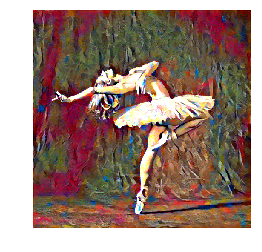

In [110]:
style_img = getimage(style_imgs[2])
output_1_exp3 = nst(input_img,content_img, style_img,
         content_layers=content_layers_0,style_layers=style_layers_4,
          style_weight=1000000, content_weight=1)
_,op3=myimshow(output_1_exp3.detach(),titles[2],save=True)

Text(0.5, 1.0, 'candy')

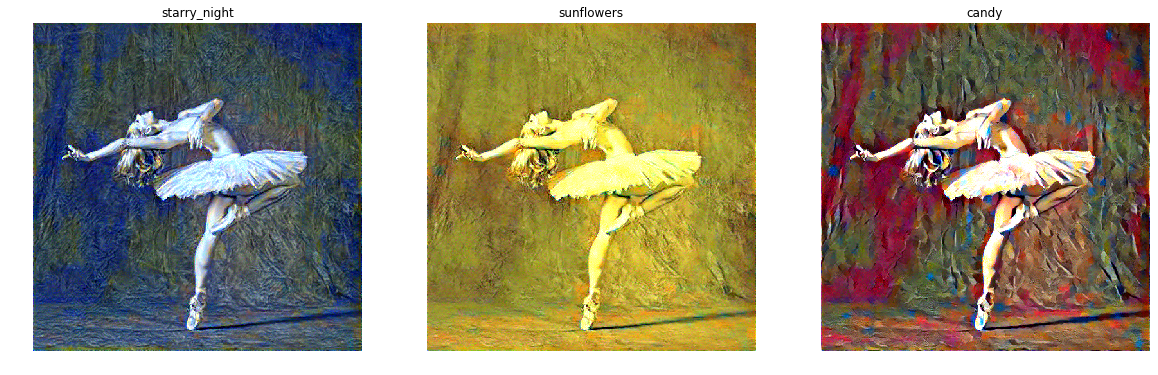

In [111]:
fig, axes = plt.subplots(ncols=3, figsize=(20,20),sharex='all' ,sharey='all')
axes[0].imshow(op1) 
axes[0].axis('off') 
axes[0].set_title('starry_night') 
axes[1].imshow(op2) 
axes[1].axis('off') 
axes[1].set_title('sunflowers')
axes[2].imshow(op3) 
axes[2].axis('off') 
axes[2].set_title('candy')